In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import h5py
import numpy as np
import tensorflow as tf
import sklearn.metrics as metrics
import itertools
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from itertools import cycle
from scipy import interp
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

In [ ]:
%cd ... # <--- INSERT HERE (...) THE PATH OF THE FOLDER

In [ ]:
ds_train_h5f = h5py.File("./train-zyx-250x190x270.h5",'r')
ds_val_h5f = h5py.File("./val-zyx-250x190x270.h5",'r')
ds_test_h5f = h5py.File("./test-zyx-250x190x270.h5",'r')

X_train = ds_train_h5f["train_X"]
Y_train = ds_train_h5f["train_Y"]

X_val = ds_val_h5f["val_X"]
Y_val = ds_val_h5f["val_Y"]

X_test = ds_test_h5f["test_X"]
Y_test = ds_test_h5f["test_Y"]

#print(X_train.shape)
#print(Y_train.shape)

#print(X_val.shape)
#print(Y_val.shape)

#print(X_test.shape)
#print(Y_test.shape)

idx_map_train = np.arange(X_train.shape[0])
np.random.shuffle(idx_map_train)

idx_map_val = np.arange(X_val.shape[0])
np.random.shuffle(idx_map_val)

idx_map_test = np.arange(X_test.shape[0])
np.random.shuffle(idx_map_test)

In [ ]:
def generate_batches_from_train_hdf5_file(hdf5_file, batch_size, idx_map):
  file_size = len(hdf5_file['train_Y'])

  while 1:
    # Count how many entries we have read
    n_entries = 0
    # As long as we haven't read all entries from the file: keep reading
    while n_entries < (file_size - batch_size):
      # Start the next batch at index 0
      # Create numpy arrays of input data (features)
      xs = hdf5_file['train_X'][n_entries: n_entries + batch_size,:,:,:]
      xs = np.array(xs)
      xs = xs[..., np.newaxis]

      ys = hdf5_file['train_Y'][n_entries:n_entries + batch_size]
      ys = np.array(ys)

      # We have read one more batch from this file
      n_entries += batch_size
      yield (xs, ys)

In [ ]:
def generate_batches_from_val_hdf5_file(hdf5_file, batch_size, idx_map):
  file_size = len(hdf5_file['val_Y'])

  while 1:
    # Count how many entries we have read
    n_entries = 0
    # As long as we haven't read all entries from the file: keep reading
    while n_entries < (file_size - batch_size):
      # Start the next batch at index 0
      # Create numpy arrays of input data (features)
      xs = hdf5_file['val_X'][n_entries: n_entries + batch_size,:,:,:]
      xs = np.array(xs)
      xs = xs[..., np.newaxis]

      ys = hdf5_file['val_Y'][n_entries:n_entries + batch_size]
      ys = np.array(ys)

      # We have read one more batch from this file
      n_entries += batch_size
      yield (xs, ys)

In [ ]:
def generate_batches_from_test_hdf5_file(hdf5_file, batch_size, idx_map):
  file_size = len(hdf5_file['test_Y'])

  while 1:
    # Count how many entries we have read
    n_entries = 0
    # As long as we haven't read all entries from the file: keep reading
    while n_entries < (file_size - batch_size):
      # Start the next batch at index 0
      # Create numpy arrays of input data (features)
      xs = hdf5_file['test_X'][n_entries: n_entries + batch_size,:,:,:]
      xs = np.array(xs)
      xs = xs[..., np.newaxis]

      ys = hdf5_file['test_Y'][n_entries:n_entries + batch_size]
      ys = np.array(ys)

      # We have read one more batch from this file
      n_entries += batch_size
      yield (xs, ys)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.figure(figsize=(6, 6), dpi=80)

  im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #plt.text(j, i, round(cm[i, j],2),
    plt.text(j, i, format(cm[i, j],'.0f'),
      horizontalalignment="center",
      color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im, cax=cax)

# PERFORMANCE EVALUATION

In [ ]:
### 3 ###

def getConvLSTMModel(verbose=True):

  model = models.Sequential()
  model.add(layers.ConvLSTM2D(filters=8,
                              kernel_size=(3, 3),
                              input_shape=(250, 190, 270, 1),
                              name="convlstm2d_1"))
  model.add(layers.Dropout(0.7,
                           name="dropout_1"))
  model.add(layers.Flatten(name="flatten_1"))
  model.add(layers.Dense(128,
                         activation="relu",
                         name="dense_1"))
  model.add(layers.Dropout(0.3,
                           name="dropout_2"))
  model.add(layers.Dense(2,
                         activation='softmax',
                         name="dense_2"))
  if verbose:
    model.summary()

  opt = tf.keras.optimizers.SGD(learning_rate=0.001)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

  return model

In [ ]:
model = getConvLSTMModel(True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convlstm2d_1 (ConvLSTM2D)   (None, 188, 268, 8)       2624      
                                                                 
 dropout_1 (Dropout)         (None, 188, 268, 8)       0         
                                                                 
 flatten_1 (Flatten)         (None, 403072)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               51593344  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 51,596,226
Trainable params: 51,596,226
No

In [ ]:
classes = ['LUAD','LUSC']
my_batch_size = 1
my_test_steps = int(60//my_batch_size)

generator_test = generate_batches_from_test_hdf5_file(ds_test_h5f, 1, idx_map_test)

model_best = tf.keras.models.load_model("./model-convlstm-3.h5")

In [ ]:
### 5 ###

input_shape1 = (190,270,1)

def getConvModel(verbose=True):

  model = models.Sequential()

  model.add(layers.InputLayer(input_shape=input_shape1))
  model.add(layers.Conv2D(filters=32,
                          kernel_size=(3,3),
                          padding="same",
                          activation="relu",
                          name="conv2d_1"))
  model.add(layers.MaxPool2D(pool_size=(2,2),
                             strides=(2,2),
                             name="max_pool2d_1"))
  model.add(layers.Conv2D(filters=64,
                          kernel_size=(3,3),
                          padding="same",
                          activation="relu",
                          name="conv2d_2"))
  model.add(layers.MaxPool2D(pool_size=(2,2),
                             strides=(2,2),
                             name="max_pool2d_2"))
  model.add(layers.Conv2D(filters=128,
                          kernel_size=(3,3),
                          padding="same",
                          activation="relu",
                          name="conv2d_3"))
  model.add(layers.MaxPool2D(pool_size=(2,2),
                             strides=(2,2),
                             name="max_pool2d_3"))
  model.add(layers.Conv2D(filters=256,
                          kernel_size=(3,3),
                          padding="same",
                          activation="relu",
                          name="conv2d_4"))
  model.add(layers.Conv2D(filters=256,
                          kernel_size=(3,3),
                          padding="same",
                          activation="relu",
                          name="conv2d_5"))
  model.add(layers.Conv2D(filters=256,
                          kernel_size=(3,3),
                          padding="same",
                          activation="relu",
                          name="conv2d_6"))
  model.add(layers.BatchNormalization(axis=-1,
                                      momentum=0.99,
                                      epsilon=0.001,
                                      center=True,
                                      scale=True,
                                      beta_initializer="zeros",
                                      gamma_initializer="ones",
                                      moving_mean_initializer="zeros",
                                      moving_variance_initializer="ones",
                                      name="batch_norm_1"))
  model.add(layers.Activation("relu",
                              name="activation_1"))
  model.add(layers.MaxPool2D(pool_size=(2,2),
                             strides=(2,2),
                             name="max_pool2d_4"))

  if verbose:
    model.summary()

  return model

In [ ]:
input_shape2 = (250,190,270,1)

def getNeuralNet(getConvModel, verbose=True):
  """
  Creates the model composed of time-distributed 2D CNN + ConvLSTM with the sequential API: https://keras.io/models/sequential/

    Parameters
    ----------
    getConvModel - Callable[[bool], Sequential]
                   Function that instantiates the Convolutional model to be applied in a time distributed fashion
                   The parameter is a boolean True for verbose output, False otherwise
    verbose - bool
              If True prints the model summary (default True)

    Returns
    ----------
    model - Sequential
            The instantiated model
  """
  model = models.Sequential()
  model.add(layers.TimeDistributed(getConvModel(),
                                   input_shape=input_shape2,
                                   name="time_distributed_1"))
  model.add(layers.ConvLSTM2D(64,
                              kernel_size=(3,3),
                              name="convlstm2d_1"))
  model.add(layers.Dropout(0.6,
                           name="dropout_1"))
  model.add(layers.Flatten(name="flatten_1"))
  model.add(layers.Dense(128,
                         activation="relu",
                         name="dense_1"))
  model.add(layers.Dropout(0.5,
                           name="dropout_2"))
  model.add(layers.Dense(2,
                         activation='softmax',
                         name="dense_2"))
  if verbose:
    model.summary()

  opt = tf.keras.optimizers.SGD(learning_rate=0.001)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

  return model

In [ ]:
model = getNeuralNet(getConvModel, True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 190, 270, 32)      320       
                                                                 
 max_pool2d_1 (MaxPooling2D)  (None, 95, 135, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 135, 64)       18496     
                                                                 
 max_pool2d_2 (MaxPooling2D)  (None, 47, 67, 64)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 67, 128)       73856     
                                                                 
 max_pool2d_3 (MaxPooling2D)  (None, 23, 33, 128)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 33, 256)      

In [ ]:
classes = ['LUAD','LUSC']
my_batch_size = 1
my_test_steps = int(60//my_batch_size)

generator_test = generate_batches_from_test_hdf5_file(ds_test_h5f, 1, idx_map_test)

model_best = tf.keras.models.load_model("./model-tdcnn+convlstm-5.h5")


# STRATIFICATION

## LLL

              precision    recall  f1-score   support

        LUAD       1.00      1.00      1.00         5
        LUSC       1.00      1.00      1.00         7

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



<ipython-input-24-10d2a8ec4ff2>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


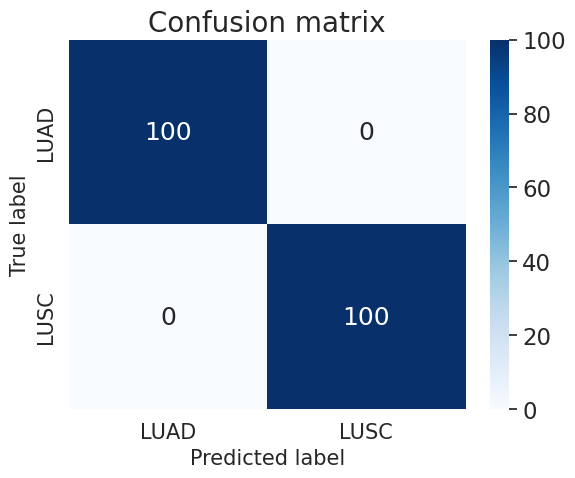

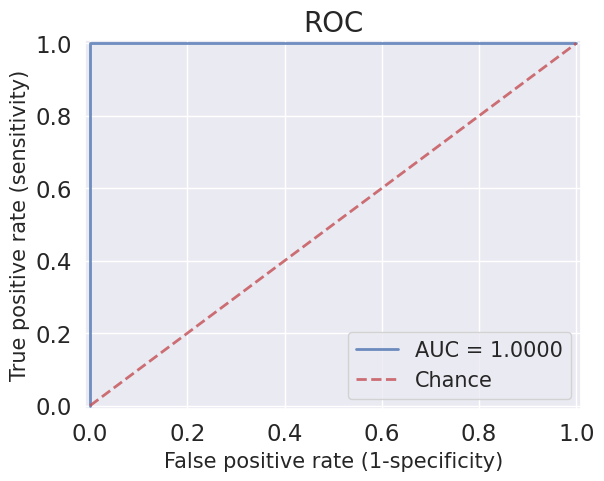

In [ ]:
pred = pd.read_excel(r"./LLL-prediction-convlstm-3.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./LLL-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

              precision    recall  f1-score   support

        LUAD       0.67      0.80      0.73         5
        LUSC       0.83      0.71      0.77         7

    accuracy                           0.75        12
   macro avg       0.75      0.76      0.75        12
weighted avg       0.76      0.75      0.75        12



<ipython-input-25-55ec371109d7>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


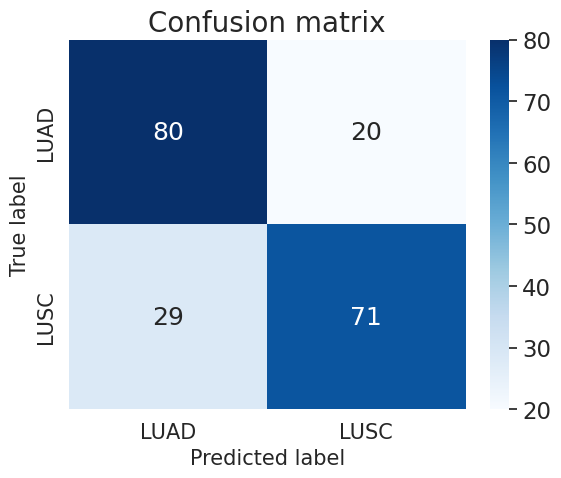

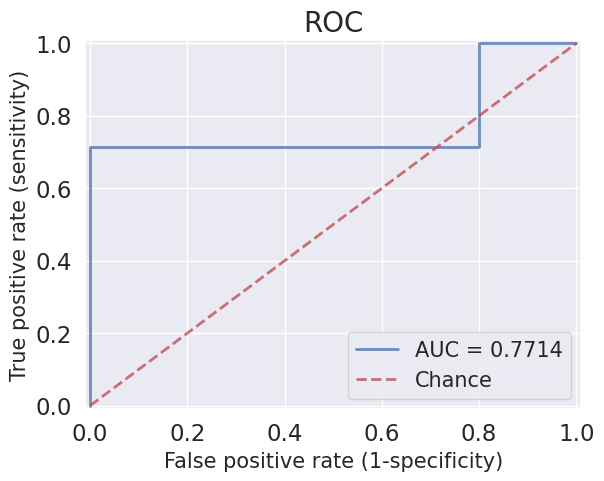

In [ ]:
pred = pd.read_excel(r"./LLL-prediction-tdcnnconvlstm-5.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./LLL-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## LUL

              precision    recall  f1-score   support

        LUAD       0.88      0.88      0.88         8
        LUSC       0.89      0.89      0.89         9

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17



<ipython-input-26-a873ad98bc2c>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


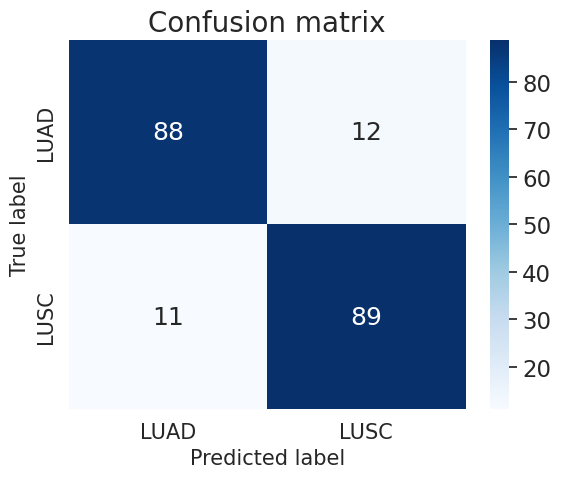

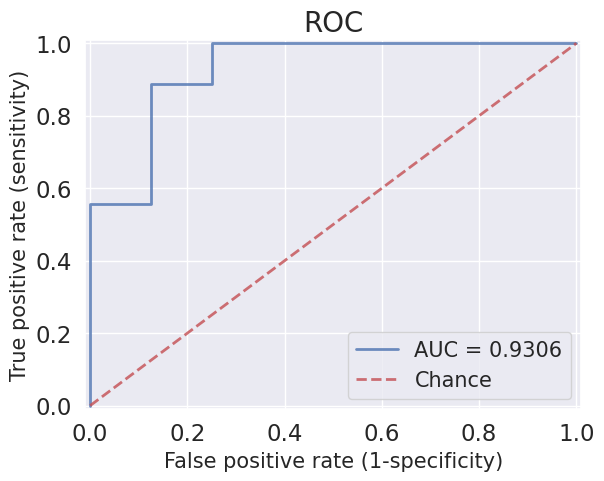

In [ ]:
pred = pd.read_excel(r"./LUL-prediction-convlstm-3.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./LUL-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

              precision    recall  f1-score   support

        LUAD       1.00      0.62      0.77         8
        LUSC       0.75      1.00      0.86         9

    accuracy                           0.82        17
   macro avg       0.88      0.81      0.81        17
weighted avg       0.87      0.82      0.82        17



<ipython-input-27-640721145cc1>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


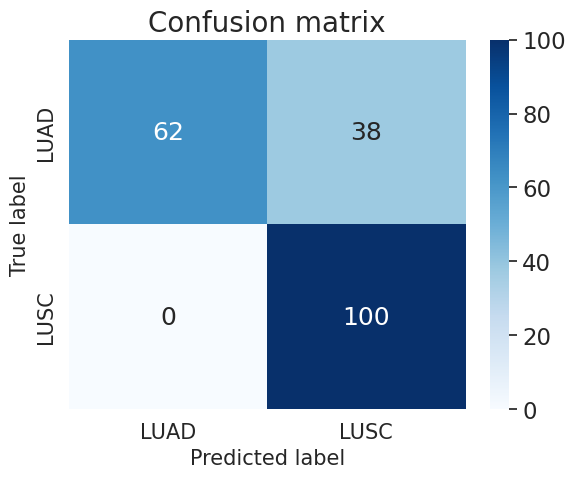

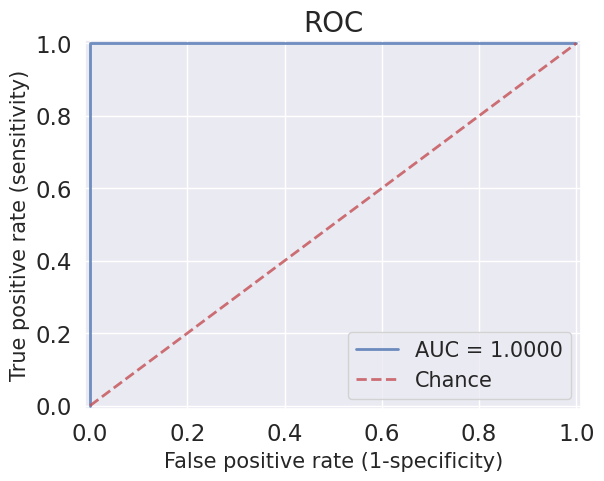

In [ ]:
pred = pd.read_excel(r"./LUL-prediction-tdcnnconvlstm-5.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./LUL-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## RLL

              precision    recall  f1-score   support

        LUAD       1.00      0.86      0.92         7
        LUSC       0.75      1.00      0.86         3

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10



<ipython-input-28-867609c5dcbf>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


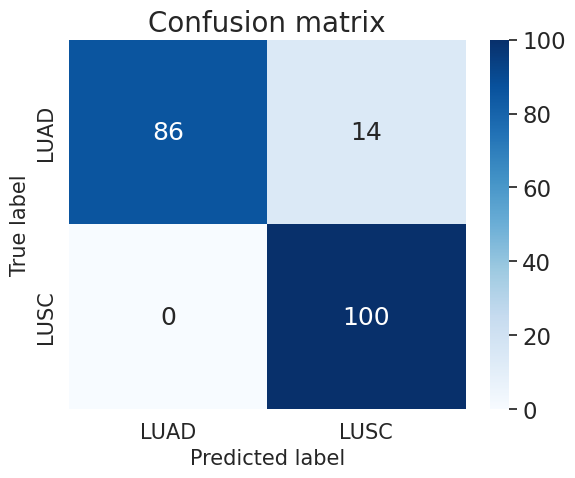

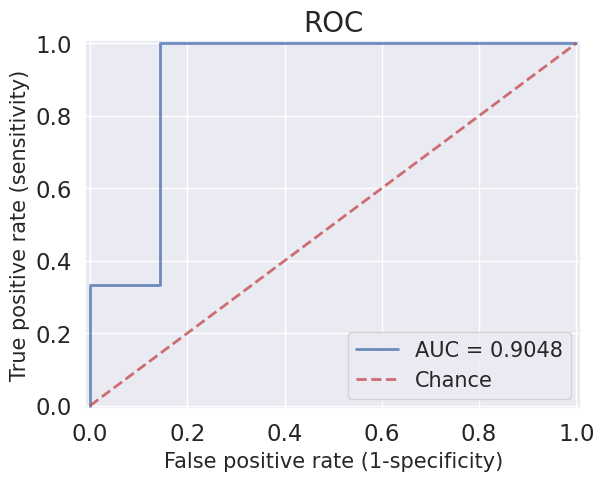

In [ ]:
pred = pd.read_excel(r"./RLL-prediction-convlstm-3.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./RLL-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

              precision    recall  f1-score   support

        LUAD       1.00      0.86      0.92         7
        LUSC       0.75      1.00      0.86         3

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10



<ipython-input-29-1681fff61744>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


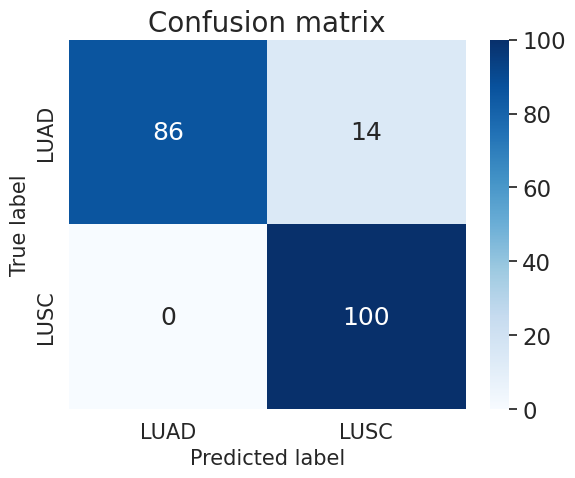

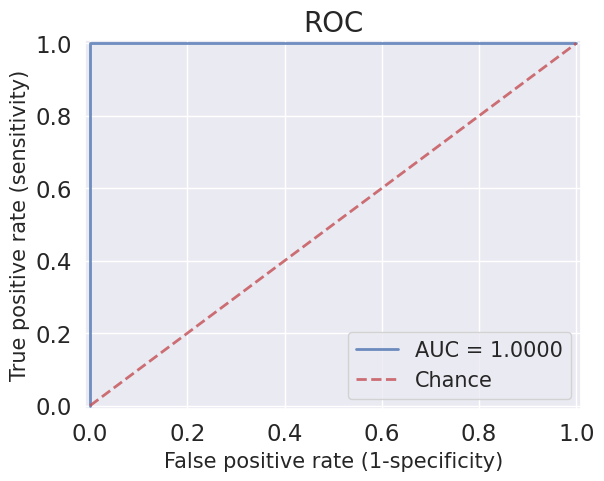

In [ ]:
pred = pd.read_excel(r"./RLL-prediction-tdcnnconvlstm-5.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./RLL-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## RML

              precision    recall  f1-score   support

        LUAD       1.00      1.00      1.00         1
        LUSC       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



<ipython-input-30-12a72af9121b>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


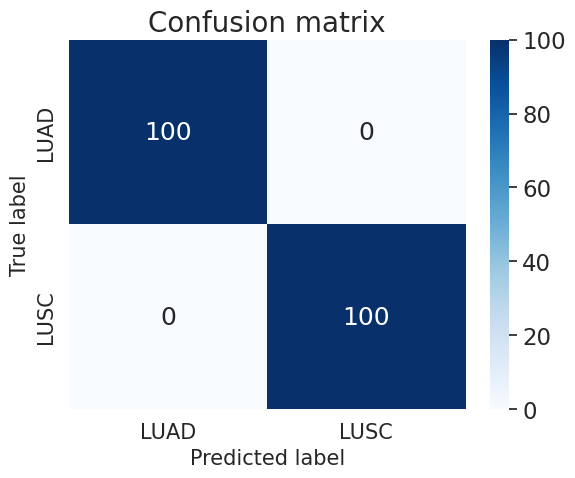

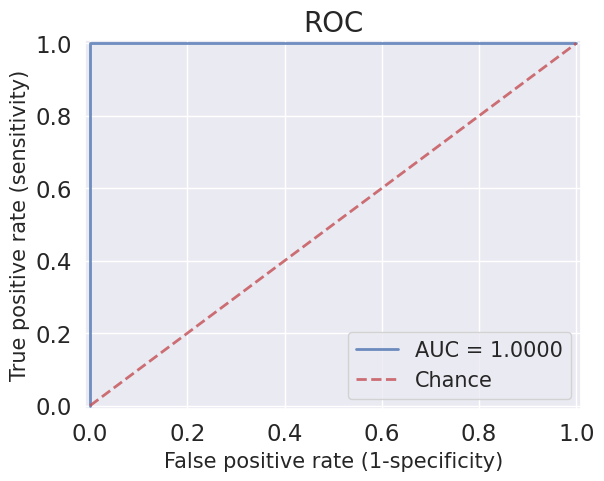

In [ ]:
pred = pd.read_excel(r"./RML-prediction-convlstm-3.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./RML-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

              precision    recall  f1-score   support

        LUAD       1.00      1.00      1.00         1
        LUSC       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



<ipython-input-31-7869fbb21f6a>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


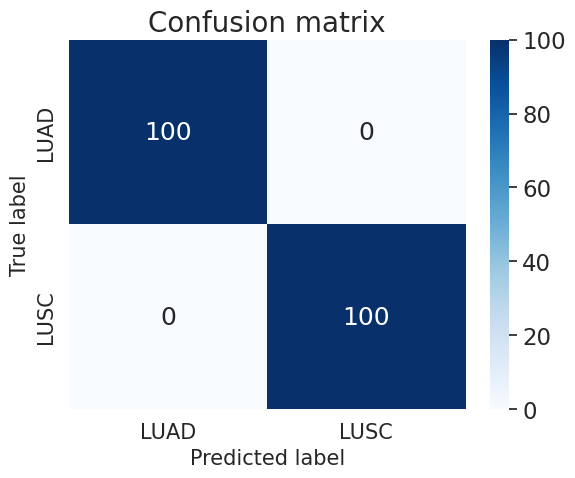

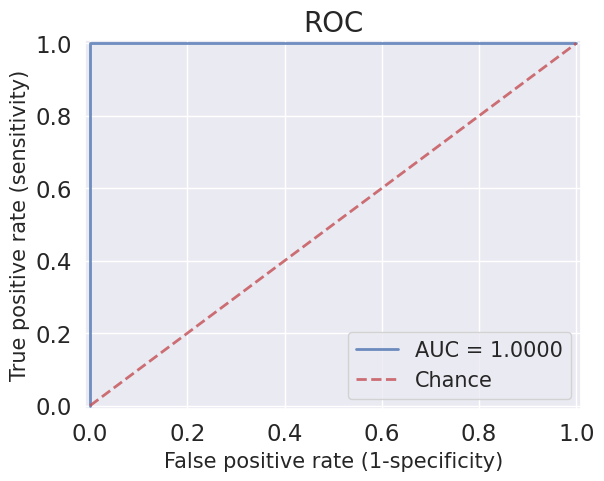

In [ ]:
pred = pd.read_excel(r"./RML-prediction-tdcnnconvlstm-5.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./RML-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## RUL

              precision    recall  f1-score   support

        LUAD       1.00      0.91      0.95        11
        LUSC       0.89      1.00      0.94         8

    accuracy                           0.95        19
   macro avg       0.94      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



<ipython-input-32-fe1c19a2e5ed>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


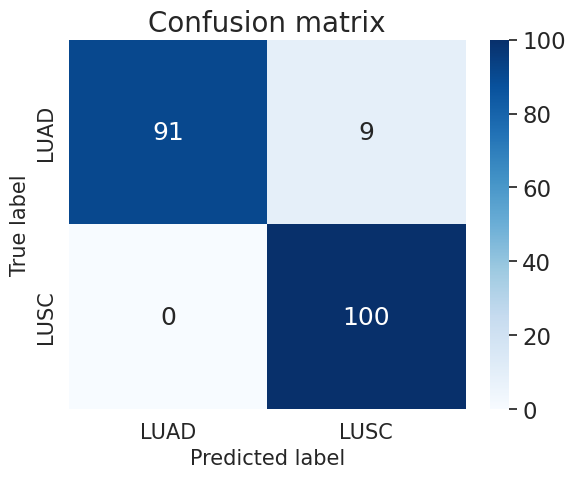

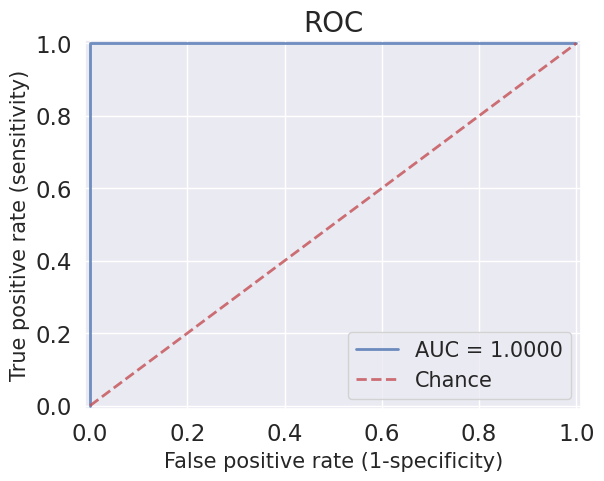

In [ ]:
pred = pd.read_excel(r"./RUL-prediction-convlstm-3.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./RUL-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

              precision    recall  f1-score   support

        LUAD       1.00      0.64      0.78        11
        LUSC       0.67      1.00      0.80         8

    accuracy                           0.79        19
   macro avg       0.83      0.82      0.79        19
weighted avg       0.86      0.79      0.79        19



<ipython-input-33-eb7ec658bfc5>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


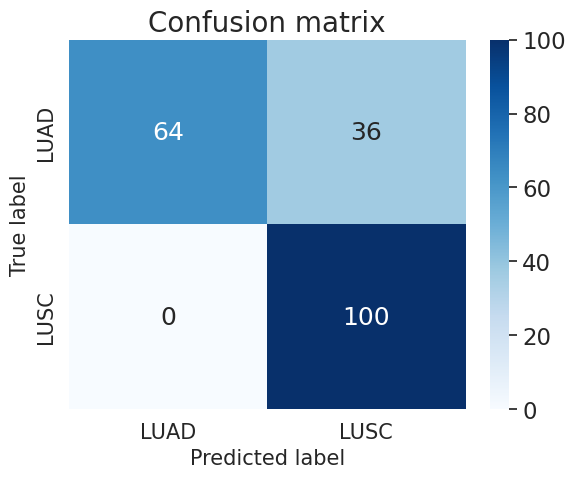

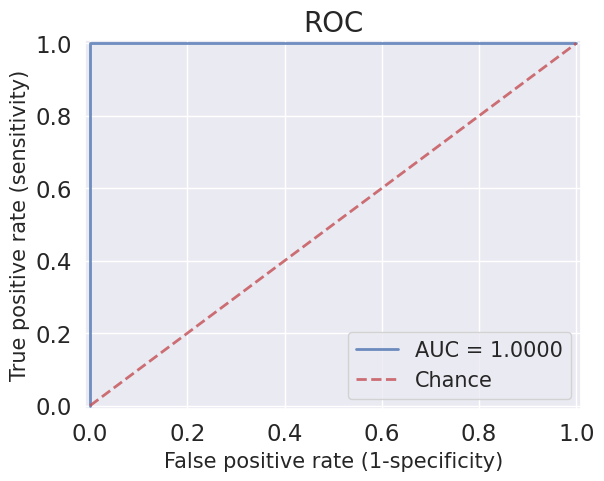

In [ ]:
pred = pd.read_excel(r"./RUL-prediction-tdcnnconvlstm-5.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./RUL-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## GNA

              precision    recall  f1-score   support

        LUAD       1.00      0.82      0.90        17
        LUSC       0.57      1.00      0.73         4

    accuracy                           0.86        21
   macro avg       0.79      0.91      0.82        21
weighted avg       0.92      0.86      0.87        21



<ipython-input-34-9885823ed7d2>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


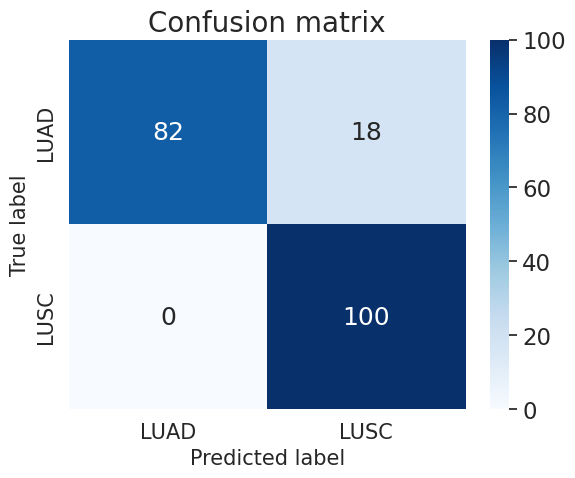

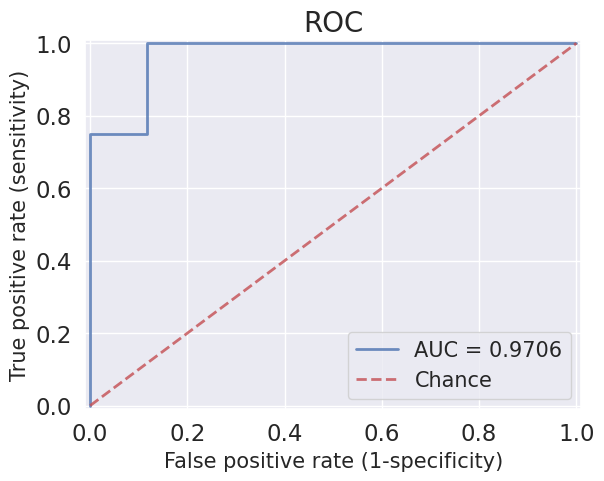

In [ ]:
pred = pd.read_excel(r"./GNA-prediction-convlstm-3.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./GNA-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

              precision    recall  f1-score   support

        LUAD       1.00      0.65      0.79        17
        LUSC       0.40      1.00      0.57         4

    accuracy                           0.71        21
   macro avg       0.70      0.82      0.68        21
weighted avg       0.89      0.71      0.74        21



<ipython-input-35-fce61f9d5124>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


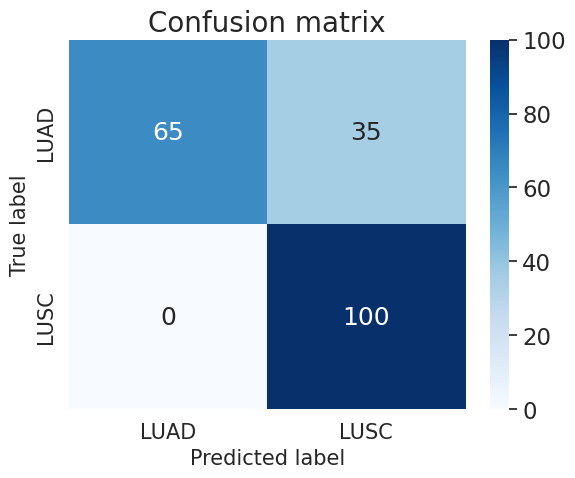

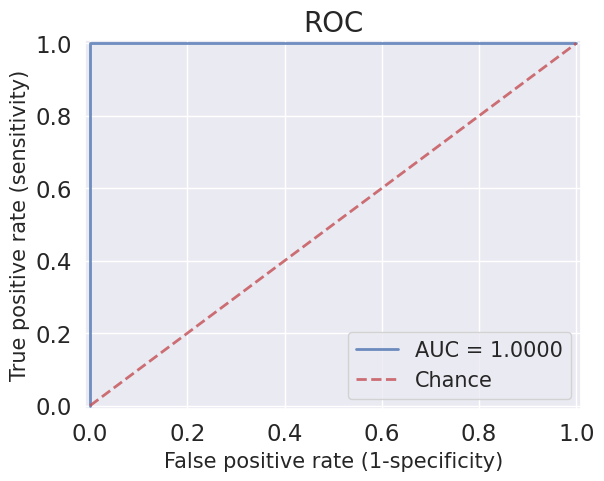

In [ ]:
pred = pd.read_excel(r"./GNA-prediction-tdcnnconvlstm-5.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./GNA-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## G1

              precision    recall  f1-score   support

        LUAD       1.00      1.00      1.00         2
        LUSC       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



<ipython-input-36-7fec139f0d3e>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


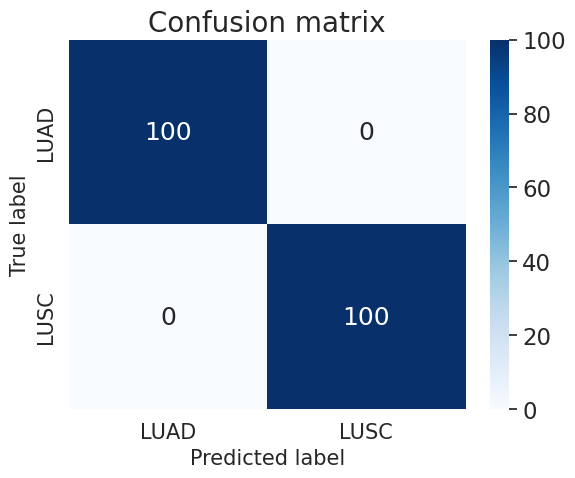

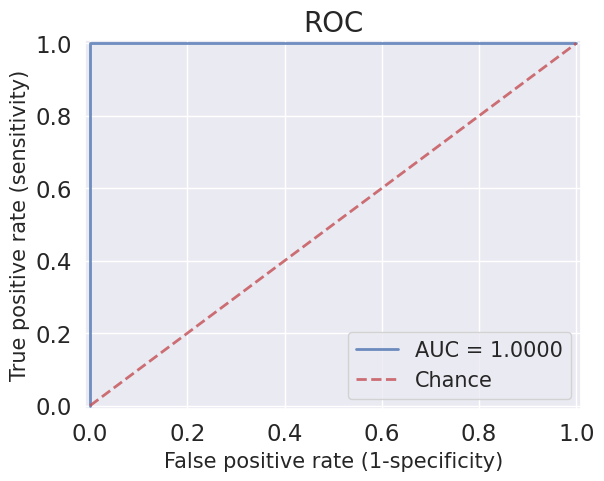

In [ ]:
pred = pd.read_excel(r"./G1-prediction-convlstm-3.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./G1-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

              precision    recall  f1-score   support

        LUAD       1.00      1.00      1.00         2
        LUSC       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



<ipython-input-37-38171c7eac96>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


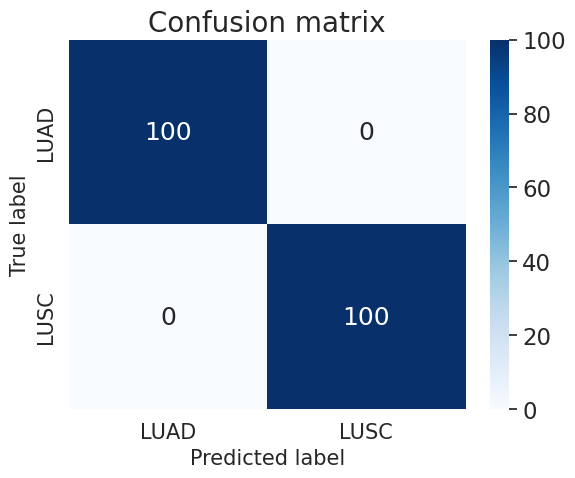

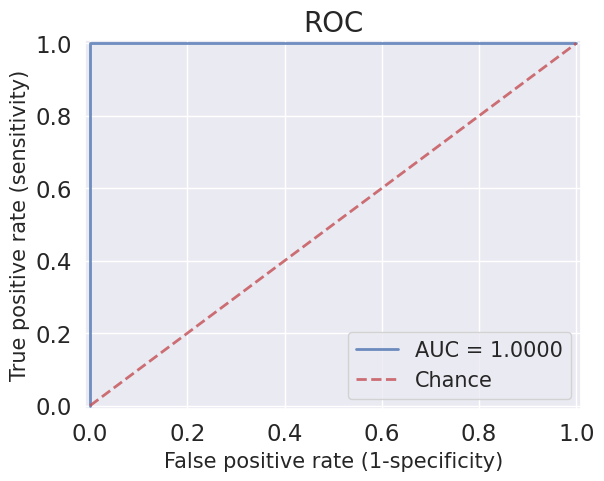

In [ ]:
pred = pd.read_excel(r"./G1-prediction-tdcnnconvlstm-5.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./G1-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## G2

              precision    recall  f1-score   support

        LUAD       0.88      1.00      0.93         7
        LUSC       1.00      0.89      0.94         9

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.95      0.94      0.94        16



<ipython-input-38-98bc534ea42b>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


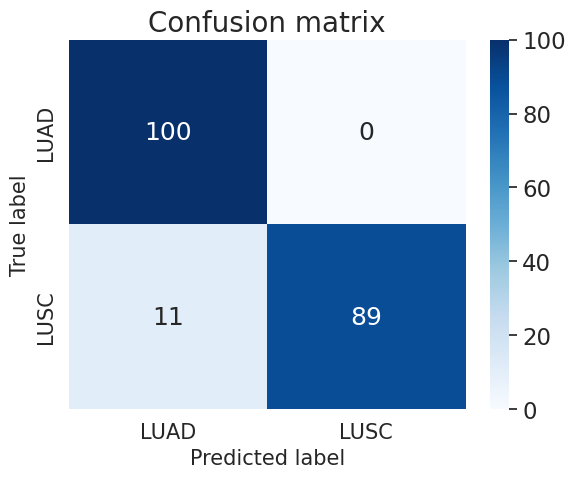

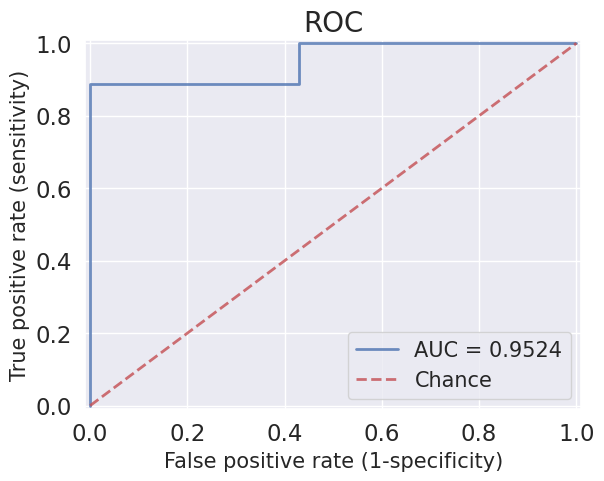

In [ ]:
pred = pd.read_excel(r"./G2-prediction-convlstm-3.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./G2-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

              precision    recall  f1-score   support

        LUAD       1.00      0.86      0.92         7
        LUSC       0.90      1.00      0.95         9

    accuracy                           0.94        16
   macro avg       0.95      0.93      0.94        16
weighted avg       0.94      0.94      0.94        16



<ipython-input-39-a5eb3cb19ca8>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


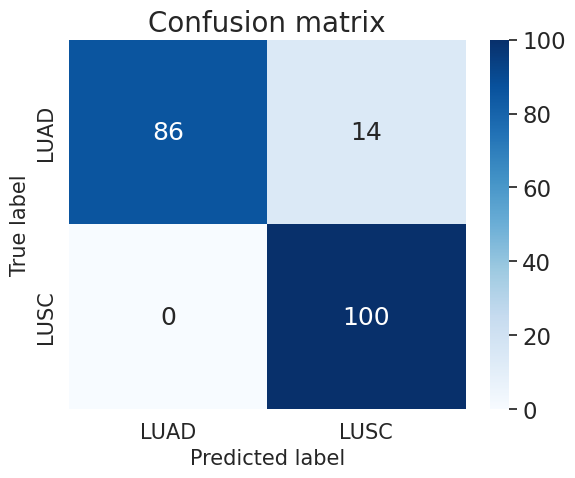

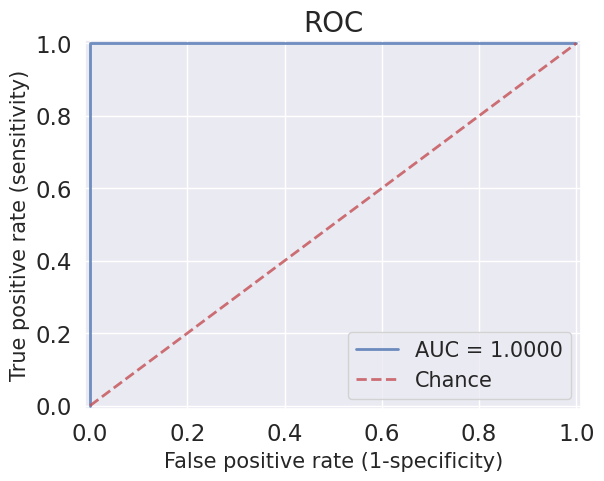

In [ ]:
pred = pd.read_excel(r"./G2-prediction-tdcnnconvlstm-5.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./G2-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## G3

              precision    recall  f1-score   support

        LUAD       1.00      0.83      0.91         6
        LUSC       0.92      1.00      0.96        12

    accuracy                           0.94        18
   macro avg       0.96      0.92      0.93        18
weighted avg       0.95      0.94      0.94        18



<ipython-input-40-4d7325c66532>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


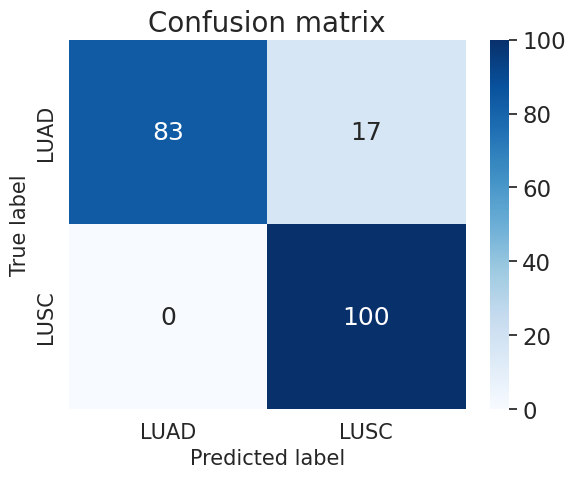

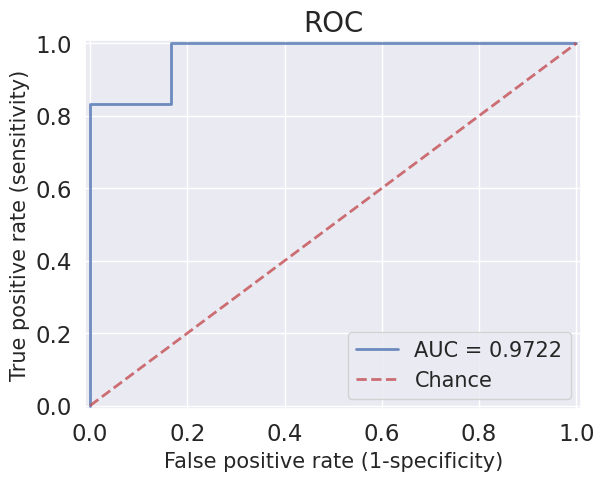

In [ ]:
pred = pd.read_excel(r"./G3-prediction-convlstm-3.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./G3-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

              precision    recall  f1-score   support

        LUAD       0.67      0.67      0.67         6
        LUSC       0.83      0.83      0.83        12

    accuracy                           0.78        18
   macro avg       0.75      0.75      0.75        18
weighted avg       0.78      0.78      0.78        18



<ipython-input-41-9e0b18003ffe>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


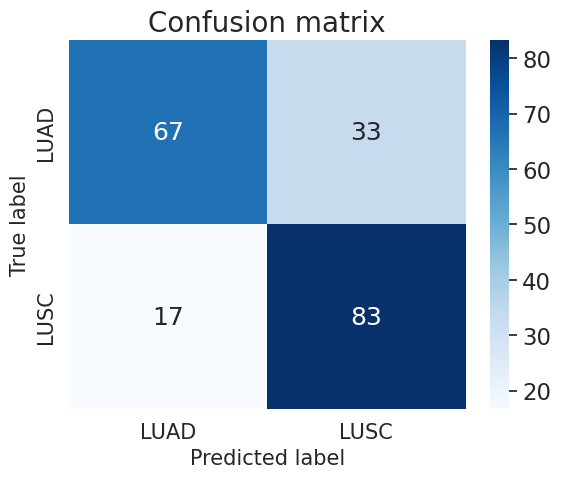

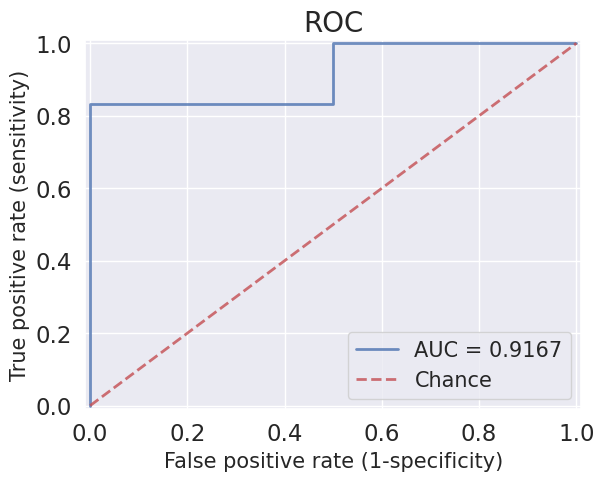

In [ ]:
pred = pd.read_excel(r"./G3-prediction-tdcnnconvlstm-5.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./G3-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## ALL

              precision    recall  f1-score   support

        LUAD       0.97      0.88      0.92        32
        LUSC       0.87      0.96      0.92        28

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



<ipython-input-42-d1030a70dbba>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


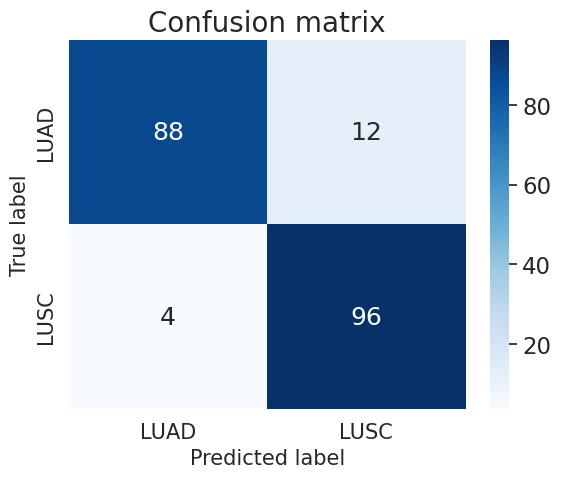

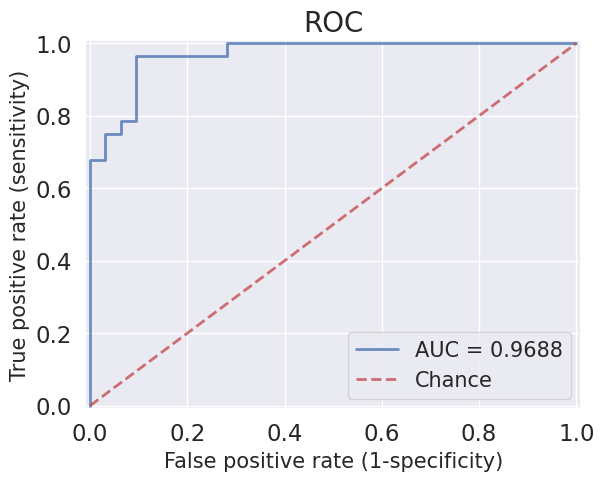

In [ ]:
pred = pd.read_excel(r"./ALL-prediction-convlstm-3.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./ALL-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

              precision    recall  f1-score   support

        LUAD       0.92      0.72      0.81        32
        LUSC       0.74      0.93      0.83        28

    accuracy                           0.82        60
   macro avg       0.83      0.82      0.82        60
weighted avg       0.84      0.82      0.82        60



<ipython-input-43-a6dd6a51e86c>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100


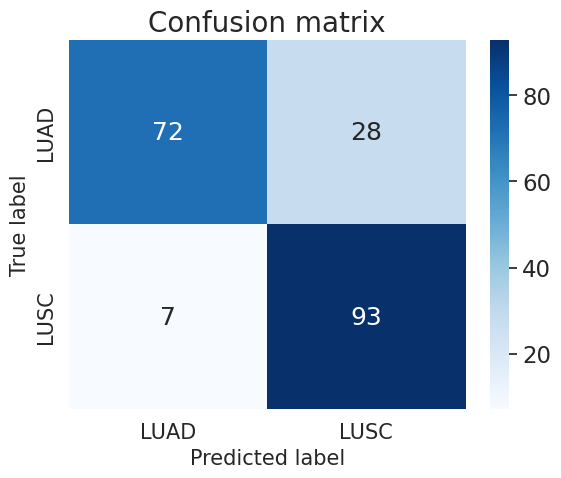

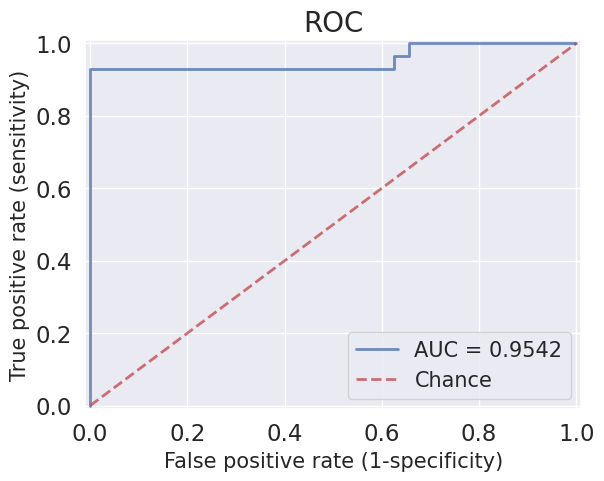

In [ ]:
pred = pd.read_excel(r"./ALL-prediction-tdcnnconvlstm-5.xlsx")
pred = np.asarray(pred)

Y = pd.read_excel(r"./ALL-ground-truth.xlsx")
Y = np.asarray(Y)

y_true = Y.argmax(axis=-1)
y_pred = pred.argmax(axis=-1)
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix_norm = (cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1, keepdims=True))*100
ax = plt.subplot()
sns.set(font_scale=1.5)
sns.heatmap(cnf_matrix_norm, annot=True, ax=ax, cmap="Blues", fmt=".0f");
label_font = {'size':'15'}
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
title_font = {'size':'20'}
ax.set_title('Confusion matrix', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels(['LUAD', 'LUSC']);
ax.yaxis.set_ticklabels(['LUAD', 'LUSC']);
plt.show()

fpr, tpr, thr = roc_curve(y_true, pred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label = 'AUC = %0.4f' % roc_auc, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate (1-specificity)', fontsize=15)
plt.ylabel('True positive rate (sensitivity)', fontsize=15)
plt.title('ROC', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()